In [1]:
%pip install opencv-python
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install tqdm

#wajib download ffmpeg di https://ffmpeg.org/download.html


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import tau
from scipy.integrate import quad
from tqdm import tqdm  
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [21]:
#ambil gambar png
img = cv2.imread('gambar1.png', cv2.IMREAD_GRAYSCALE)

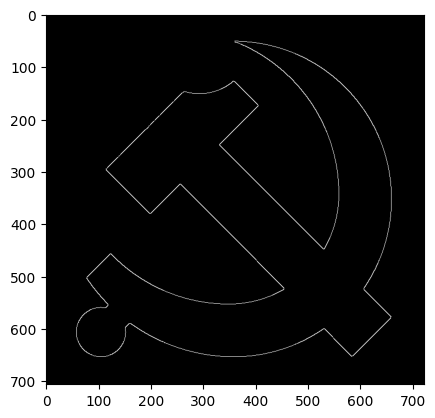

In [22]:
# Load your image (assuming it's already in grayscale)
gray = img.copy()

# Apply Gaussian blur to the grayscale image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 100, 200)

# Display the result
plt.imshow(edges, cmap='gray')
plt.show()

In [28]:
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path.")
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Adjust these thresholds
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found. Adjust Canny thresholds or check image quality.")
    # This chooses the contour with the maximum area; consider other criteria if needed.
    max_contour = max(contours, key=cv2.contourArea)

    # Extract contour coordinates
    contour = max_contour.squeeze()
    x_list, y_list = contour[:, 0].astype(np.float64), -contour[:, 1].astype(np.float64)
    x_list -= np.mean(x_list)
    y_list -= np.mean(y_list)
    return x_list, y_list


Menghitung Koefisien Fourier (Mohon Tunggu):   0%|          | 0/401 [00:00<?, ?it/s]c:\Users\Sebastian\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_6348\1502046542.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(lambda t: f(t) * np.exp(-n * 1j * t), 0, tau)
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_6348\150204654

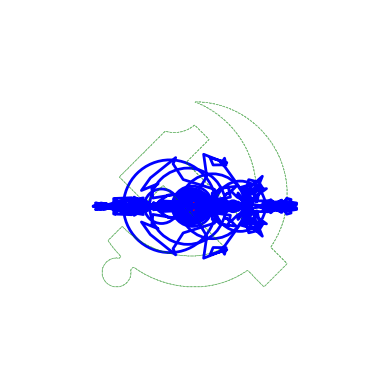

In [29]:

def compute_fourier_coefficients(x_list, y_list, order=100):
    tau = 2 * np.pi
    t_list = np.linspace(0, tau, len(x_list))
    f = lambda t: np.interp(t, t_list, x_list + 1j * y_list)
    
    c = []
    with tqdm(total=2*order + 1, desc="Menghitung Koefisien Fourier (Mohon Tunggu)") as pbar:
        for n in range(-order, order + 1):
            result, _ = quad(lambda t: f(t) * np.exp(-n * 1j * t), 0, tau)
            coef = result / tau
            c.append(coef)
            pbar.update(1)
    return np.array(c)

def animate_epicycle(x_list, y_list, c, xlim, ylim):
    fig, ax = plt.subplots()
    ax.plot(x_list, y_list, 'g--', linewidth=0.5, alpha=0.5) 
    ax.set_xlim(xlim[0] - 300, xlim[1] + 300)  
    ax.set_ylim(ylim[0] - 300, ylim[1] + 300)
    ax.set_aspect('equal')
    ax.set_axis_off()

    lines = [ax.plot([], [], 'r-')[0] for _ in range(2 * len(c) + 1)]
    circles = [plt.Circle((0, 0), 0, color='blue', fill=False, linewidth=2) for _ in range(len(c))]
    for circle in circles:
        ax.add_artist(circle)

    point, = ax.plot([], [], 'ro')
    drawing, = ax.plot([], [], 'b-', linewidth=2)  

    path = []

    def init():
        for line in lines:
            line.set_data([], [])
        point.set_data([], [])
        drawing.set_data([], [])
        for circle in circles:
            circle.center = (0, 0)
            circle.radius = 0
        return lines + [point, drawing] + circles

    def update(frame):
        time = np.linspace(0, tau, num=600)
        sums = np.cumsum([c[k] * np.exp(1j * (k - len(c)//2) * time[frame]) for k in range(len(c))], axis=0)
        lines_data = [[(0, 0)] + [(s.real, s.imag) for s in sums]]

        x_prev, y_prev = 0, 0
        for line, circle, s in zip(lines, circles, sums):
            x, y = s.real, s.imag
            line.set_data([x_prev, x], [y_prev, y])
            circle.center = (x_prev, y_prev)
            circle.radius = np.abs(s)
            x_prev, y_prev = x, y

        point.set_data(sums[-1].real, sums[-1].imag)
        path.append((sums[-1].real, sums[-1].imag))
        drawing.set_data(*zip(*path))
        return lines + [point, drawing] + circles

    ani = FuncAnimation(fig, update, frames=600, init_func=init, blit=False)
    writer = FFMpegWriter(fps=30)
    ani.save("video.mp4", writer=writer)

# Load and process the image
x_list, y_list = load_and_process_image("gambar1.png")
xlim, ylim = (min(x_list), max(x_list)), (min(y_list), max(y_list))
order = 200  # Increase order here
coefficients = compute_fourier_coefficients(x_list, y_list, order)
animate_epicycle(x_list, y_list, coefficients, xlim, ylim)

In [11]:
import cv2
image = cv2.imread('luffy.jpg')
print(image)

[[[ 73  98 218]
  [ 73  98 218]
  [ 73  98 218]
  ...
  [ 86  96 174]
  [ 86  96 174]
  [ 86  96 174]]

 [[ 73  98 218]
  [ 73  98 218]
  [ 73  98 218]
  ...
  [ 86  96 174]
  [ 86  96 174]
  [ 86  96 174]]

 [[ 73  98 218]
  [ 73  98 218]
  [ 73  98 218]
  ...
  [ 86  96 174]
  [ 86  96 174]
  [ 86  96 174]]

 ...

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [118 118 118]
  [115 115 115]
  [113 113 113]]

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [123 123 123]
  [118 118 118]
  [114 114 114]]

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [132 132 132]
  [127 127 127]
  [122 122 122]]]


In [7]:
#menghitung durasi gambar
import time

start_time = time.time()
image = cv2.imread('luffy.jpg')
end_time = time.time()
elapsed_time = end_time - start_time
print("Durasi membaca gambar: ", elapsed_time, "detik")

Durasi membaca gambar:  0.019798994064331055 detik


In [8]:
#menghitung kecepatan membaca gambar dalam MB/detik

start_time = time.time()
image = cv2.imread('luffy.jpg')
end_time = time.time()
elapsed_time = end_time - start_time
image_size = 0.000001 * image.size
speed = image_size / elapsed_time
print("Kecepatan membaca gambar: ", speed, "MB/detik")

Kecepatan membaca gambar:  194.68074751069216 MB/detik


In [9]:
#konversi gambar ke matriks
import numpy as np
import cv2

image = cv2.imread('luffy.jpg')
image_matrix = np.array(image)
print(image_matrix)

[[[ 73  98 218]
  [ 73  98 218]
  [ 73  98 218]
  ...
  [ 86  96 174]
  [ 86  96 174]
  [ 86  96 174]]

 [[ 73  98 218]
  [ 73  98 218]
  [ 73  98 218]
  ...
  [ 86  96 174]
  [ 86  96 174]
  [ 86  96 174]]

 [[ 73  98 218]
  [ 73  98 218]
  [ 73  98 218]
  ...
  [ 86  96 174]
  [ 86  96 174]
  [ 86  96 174]]

 ...

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [118 118 118]
  [115 115 115]
  [113 113 113]]

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [123 123 123]
  [118 118 118]
  [114 114 114]]

 [[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [132 132 132]
  [127 127 127]
  [122 122 122]]]


In [10]:
#menghitung durasi konversi gambar ke matriks

import time
import numpy as np
import cv2

start_time = time.time()
image = cv2.imread('luffy.jpg')
image_matrix = np.array(image)
end_time = time.time()
elapsed_time = end_time - start_time
print("Durasi konversi gambar ke matriks: ", elapsed_time, "detik")

Durasi konversi gambar ke matriks:  0.021048307418823242 detik


In [14]:
#menghitung kecepatan konversi gambar ke matriks dalam MB/detik

import time
import numpy as np
import cv2

start_time = time.time()
image = cv2.imread('luffy.jpg')
image_matrix = np.array(image)
end_time = time.time()
elapsed_time = end_time - start_time
image_size = 0.000001 * image_matrix.size
speed = image_size / elapsed_time
print("Kecepatan konversi gambar ke matriks: ", speed, "MB/detik")

Kecepatan konversi gambar ke matriks:  194.60332512179227 MB/detik


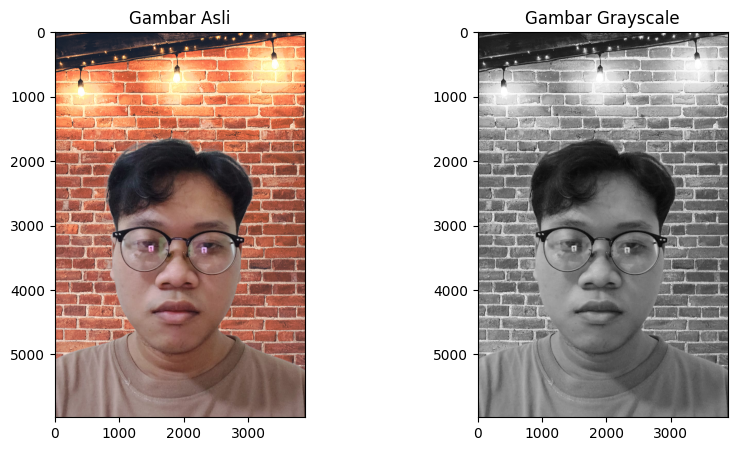

In [17]:
#konversi gambar ke grayscale
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('agil.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Gambar Grayscale')
plt.imshow(gray_image, cmap='gray')


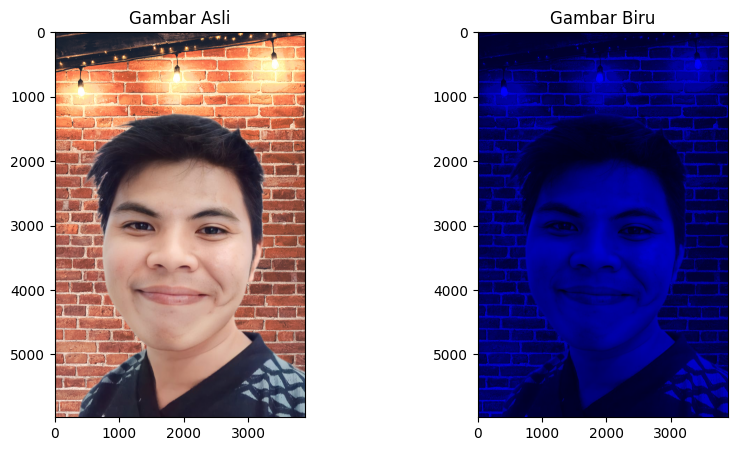

In [18]:
#konversi gambar ke warna biru
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('sebastian.jpg')
blue_image = image.copy()
blue_image[:, :, 1] = 0
blue_image[:, :, 2] = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Gambar Biru')
plt.imshow(cv2.cvtColor(blue_image, cv2.COLOR_BGR2RGB))

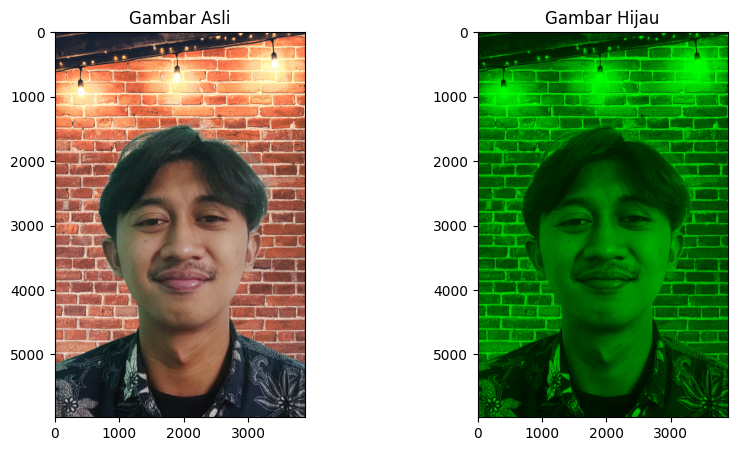

In [19]:
#konversi gambar ke warna hijau
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('ridho.jpg')
green_image = image.copy()
green_image[:, :, 0] = 0
green_image[:, :, 2] = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Gambar Hijau')
plt.imshow(cv2.cvtColor(green_image, cv2.COLOR_BGR2RGB))

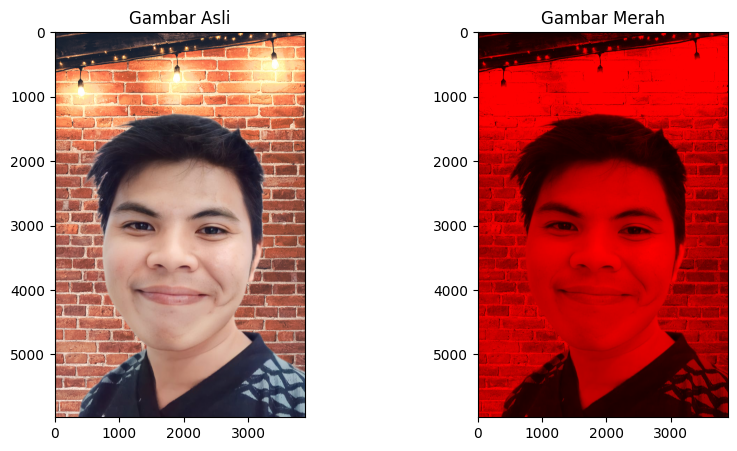

In [29]:
#konversi gambar ke warna merah
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('sebastian.jpg')
red_image = image.copy()
red_image[:, :, 0] = 0
red_image[:, :, 1] = 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Gambar Merah')
plt.imshow(cv2.cvtColor(red_image, cv2.COLOR_BGR2RGB))

In [32]:
#berapa persen gambar asli yang warnanya diubah ke biru, merah, dan hijau
import cv2
import numpy as np

image = cv2.imread('sebastian.jpg')
blue_image = image.copy()
blue_image[:, :, 1] = 0
blue_image[:, :, 2] = 0

red_image = image.copy()
red_image[:, :, 0] = 0
red_image[:, :, 1] = 0

green_image = image.copy()
green_image[:, :, 0] = 0
green_image[:, :, 2] = 0

#ambil semua range warna merah yang ada
red_mask = cv2.inRange(red_image, np.array([0, 0, 0]), np.array([0, 255, 255]))
red_pixels = cv2.countNonZero(red_mask)

#ambil semua range warna hijau yang ada
green_mask = cv2.inRange(green_image, np.array([0, 0, 0]), np.array([255, 0, 255]))
green_pixels = cv2.countNonZero(green_mask)

#ambil semua range warna biru yang ada
blue_mask = cv2.inRange(blue_image, np.array([0, 0, 0]), np.array([255, 255, 0]))
blue_pixels = cv2.countNonZero(blue_mask)

total_pixels = image.shape[0] * image.shape[1]
red_percentage = (red_pixels / total_pixels) * 100
green_percentage = (green_pixels / total_pixels) * 100
blue_percentage = (blue_pixels / total_pixels) * 100

print("Persentase warna merah: ", red_percentage, "%")
print("Persentase warna hijau: ", green_percentage, "%")
print("Persentase warna biru: ", blue_percentage, "%")

Persentase warna merah:  100.0 %
Persentase warna hijau:  0.0 %
Persentase warna biru:  100.0 %


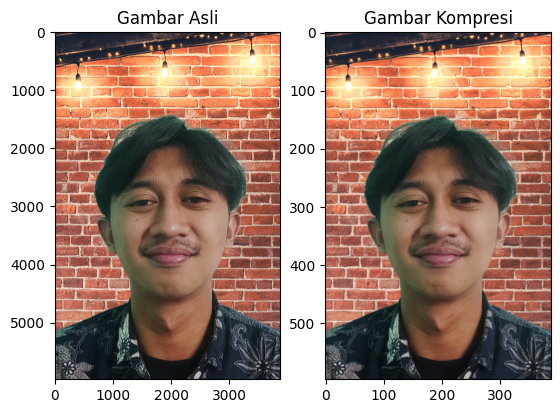

Ukuran gambar ridho: 67918.9453125 KB
Ukuran gambar ridho setelah dikompresi: 678.62109375 KB
Pengurangan memory gambar: 99.00083682008368 %


In [27]:
#kompresi gambar
def kompresi_gambar(image, skala_reduksi):
    lebar = int(image.shape[1] * skala_reduksi / 100)
    tinggi = int(image.shape[0] * skala_reduksi / 100)
    dim = (lebar, tinggi)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

ridho = cv2.imread('ridho.jpg')
ridho_kompresi = kompresi_gambar(ridho, 10)

#tampilkan gambar sebelum dan sesudah konversi dalam satu gambar    
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(ridho, cv2.COLOR_BGR2RGB))
ax[0].set_title('Gambar Asli')
ax[1].imshow(cv2.cvtColor(ridho_kompresi, cv2.COLOR_BGR2RGB))
ax[1].set_title('Gambar Kompresi')
plt.show()

#ukuran memory gambar sebelum dan sesudah kompresi dalam kilobyte
print('Ukuran gambar ridho:', ridho.nbytes / 1024, 'KB')
print('Ukuran gambar ridho setelah dikompresi:', ridho_kompresi.nbytes / 1024, 'KB')

pengurangan_memory = (1 - ridho_kompresi.nbytes / ridho.nbytes) * 100
print('Pengurangan memory gambar:', pengurangan_memory, '%')


In [75]:
#hitung durasi kompresi gambar
import time
import cv2

#kompresi gambar sebanyak 100 kali
start_time = time.time()
for i in range(100):
    ridho_kompresi = kompresi_gambar(ridho, 10)
end_time = time.time()
elapsed_time = end_time - start_time

rata_rata = elapsed_time / 100

print("Rata-rata durasi kompresi gambar: ", rata_rata, "detik")

Rata-rata durasi kompresi gambar:  0.598479630947113 detik


In [77]:
#hitung rata-rata kecepatan kompresi gambar dalam MB/detik dengan 100 gambar yang dikompresi
start_time = time.time()
for i in range(100):
    ridho_kompresi = kompresi_gambar(ridho, 10)
end_time = time.time()
elapsed_time = end_time - start_time

memory_size = ridho_kompresi.nbytes / (1024*2)
speed = memory_size / elapsed_time

rata_rata = speed / 100

print("Rata-rata kecepatan kompresi gambar: ", rata_rata, "MB/detik")

Rata-rata kecepatan kompresi gambar:  5.792371234625896 MB/detik


In [58]:
ridho = cv2.imread('ridho.jpg')
memory_size = ridho.nbytes / (1024*2)

print('Ukuran memory gambar ridho:', memory_size, 'KB')


Ukuran memory gambar ridho: 33959.47265625 KB


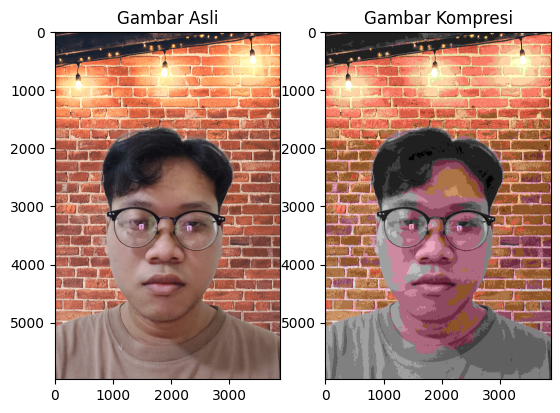

In [70]:
#kompresi gambar dengan kualitas 1%

def kompresi_gambar(image, kualitas):
    _, buffer = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), kualitas])
    compressed_image = cv2.imdecode(buffer, cv2.IMREAD_COLOR)
    return compressed_image

agil = cv2.imread('agil.jpg')
agil_kompresi = kompresi_gambar(agil, 1)

#tampilkan gambar sebelum dan sesudah konversi dalam satu gambar
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(agil, cv2.COLOR_BGR2RGB))
ax[0].set_title('Gambar Asli')
ax[1].imshow(cv2.cvtColor(agil_kompresi, cv2.COLOR_BGR2RGB))
ax[1].set_title('Gambar Kompresi')
plt.show()

simpan_gambar = cv2.imwrite('agil_kompresi.jpg', agil_kompresi)

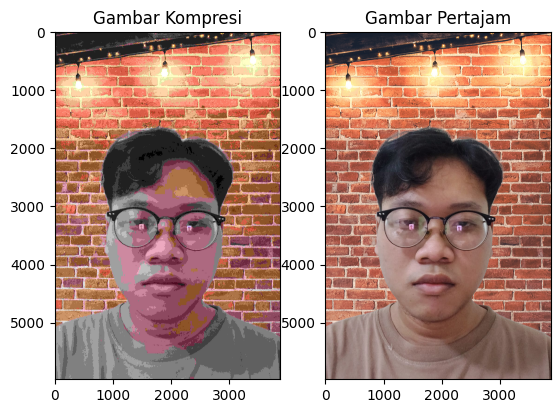

In [73]:
def sharpen_image(image, kernel):
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

agil_kompresi = cv2.imread('agil_kompresi.jpg')
agil_pertajam = sharpen_image(agil_kompresi, kernel)

#tampilkan gambar sebelum dan sesudah konversi dalam satu gambar
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(agil_kompresi, cv2.COLOR_BGR2RGB))
ax[0].set_title('Gambar Kompresi')
ax[1].imshow(cv2.cvtColor(agil_pertajam, cv2.COLOR_BGR2RGB))
ax[1].set_title('Gambar Pertajam')
plt.show()

In [80]:
#hitung rata-rata durasi pertajaman gambar
#pertajam gambar sebanyak 100 kali
start_time = time.time()
for i in range(100):
    agil_pertajam = sharpen_image(agil_kompresi, kernel)
end_time = time.time()
elapsed_time = end_time - start_time

rata_rataKonvolusi = elapsed_time / 100

print("Rata-rata durasi pertajaman gambar: ", rata_rataKonvolusi, "detik")

Rata-rata durasi pertajaman gambar:  0.06129136562347412 detik


In [81]:
#hitung rata-rata kecepatan pertajaman gambar dalam MB/detik dengan 100 gambar yang dipertajam
start_time = time.time()
for i in range(100):
    agil_pertajam = sharpen_image(agil_kompresi, kernel)
end_time = time.time()
elapsed_time = end_time - start_time

memory_size = agil_pertajam.nbytes / (1024*2)
speed = memory_size / elapsed_time
rata_rataKonvolusi = speed / 100

print("Rata-rata kecepatan pertajaman gambar: ", rata_rataKonvolusi, "MB/detik")

Rata-rata kecepatan pertajaman gambar:  57.2036574651721 MB/detik


In [82]:
def transformasi_fourier(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    shift = np.fft.fftshift(dft)  
    row, col = image.shape
    center_row, center_col = row // 2, col // 2
    
    mask = np.zeros((row, col, 2), np.uint8)
    mask[center_row - 30:center_row + 30, center_col - 30:center_col + 30] = 1
    

    fshift = shift * mask
    
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])  
    
    return img_back

def visualisasi(image, imageThen):
    plt.figure(figsize=(10, 10))
    plt.subplot(121), plt.imshow(image, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(imageThen, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()
    
sebastian = cv2.imread('sebastian.jpg', cv2.IMREAD_GRAYSCALE)
sebastian_fourier = transformasi_fourier(sebastian)
visualisasi(sebastian, sebastian_fourier)

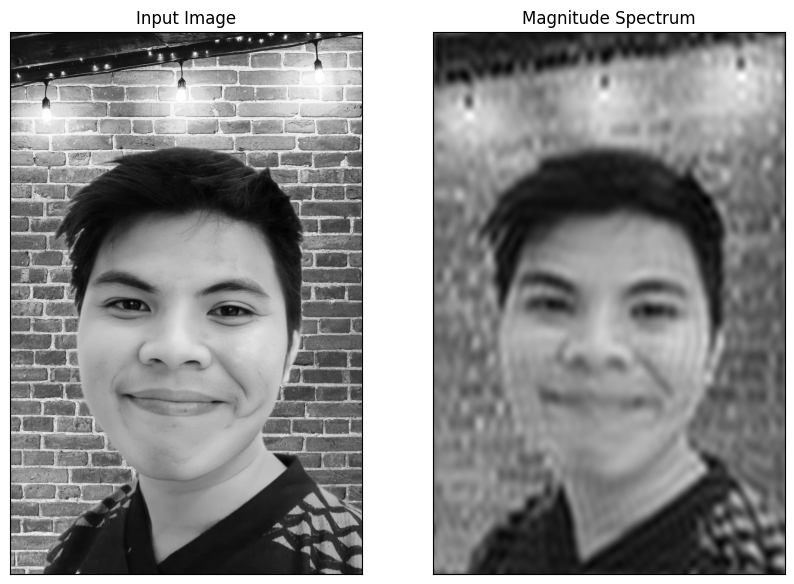

In [85]:
#durasi rata-rata transformasi fourier
#transformasi fourier gambar sebanyak 100 kali
start_time = time.time()
for i in range(100):
    sebastian_fourier = transformasi_fourier(sebastian)
end_time = time.time()
elapsed_time = end_time - start_time

rata_rataTransformasi = elapsed_time / 100

print("Rata-rata durasi transformasi fourier: ", rata_rataTransformasi, "detik")

Rata-rata durasi transformasi fourier:  2.126292850971222 detik


In [86]:
#kecepatan rata-rata transformasi fourier
#transformasi fourier gambar sebanyak 100 kali
start_time = time.time()
for i in range(100):
    sebastian_fourier = transformasi_fourier(sebastian)
end_time = time.time()
elapsed_time = end_time - start_time

memory_size = sebastian_fourier.nbytes / (1024*2)
speed = memory_size / elapsed_time
rata_rataTransformasi = speed / 100

print("Rata-rata kecepatan transformasi fourier: ", rata_rataTransformasi, "MB/detik")

Rata-rata kecepatan transformasi fourier:  2.0740601796700426 MB/detik
